In [1]:
import os
import logging
import pyxdf
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
from scipy.fft import fftshift

#path = '/Users/admin/Documents/CurrentStudy/sub-P001/ses-S002/eeg'
#path = '/Users/admin/Desktop/sub-P001/ses-S001/eeg'
path = '/Users/minle/Documents/CurrentStudy/sub-P001/ses-S001/eeg' # write directory towards xdf file
logging.basicConfig(level=logging.DEBUG)  # Use logging.INFO to reduce output.
#fname = os.path.abspath(os.path.join(os.path.dirname(path),'eeg', 'StringTest.xdf'))
#fname = os.path.abspath(os.path.join(os.path.dirname(path),'Desktop', 'sub-P001_ses-S001_task-T1_run-001_eeg.xdf'))
filename = 'sub-P001_ses-S001_task-Default_run-001_eeg.xdf'
#filename = 'sub-P001_ses-S001_task-Unchain_LeadOff1to8_run-001_eeg.xdf'
fname = os.path.abspath(os.path.join(os.path.dirname(path),'eeg', filename))
streams, fileheader = pyxdf.load_xdf(fname)

print("Found {} streams:".format(len(streams)))
for ix, stream in enumerate(streams):
    print("Stream {}: {} - type {} - uid {} - shape {} at {} Hz (effective {} Hz)".format(
        ix + 1, stream['info']['name'][0],
        stream['info']['type'][0],
        stream['info']['uid'][0],
        (int(stream['info']['channel_count'][0]), len(stream['time_stamps'])),
        stream['info']['nominal_srate'][0],
        stream['info']['effective_srate'])
    )
    if any(stream['time_stamps']):
        print("\tDuration: {} s".format(stream['time_stamps'][-1] - stream['time_stamps'][0]))
print("Done.")

INFO:pyxdf.pyxdf:Importing XDF file C:\Users\minle\Documents\CurrentStudy\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-Default_run-001_eeg.xdf...
DEBUG:pyxdf.pyxdf: Read tag: 2 at 132 bytes, length=646, StreamId=1
DEBUG:pyxdf.pyxdf:  found stream OpenBCIEEG1
DEBUG:pyxdf.pyxdf: Read tag: 3 at 780 bytes, length=180, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,1]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 965 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 22106 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 43247 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 64388 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 85529 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 106670 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  re

DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 1438733 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 1459874 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 1481015 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 4 at 1502153 bytes, length=22, StreamId=1
DEBUG:pyxdf.pyxdf: Read tag: 3 at 1502180 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 1523321 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 1544462 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 1565603 bytes, length=21128, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 1586736 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBU

DEBUG:pyxdf.pyxdf: Read tag: 3 at 2897610 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 2918751 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 2939892 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 2961053 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 4 at 2982191 bytes, length=22, StreamId=1
DEBUG:pyxdf.pyxdf: Read tag: 3 at 2982218 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 3003359 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 3024500 bytes, length=21128, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 3045633 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 3066774

DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 4377640 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 4398781 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 4419922 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 4441063 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 4 at 4462201 bytes, length=22, StreamId=1
DEBUG:pyxdf.pyxdf: Read tag: 3 at 4462228 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 4483369 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 4504510 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 4525651 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBU

DEBUG:pyxdf.pyxdf: Read tag: 3 at 5836565 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 5857706 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 5878847 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 5899988 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 5921149 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 4 at 5942287 bytes, length=22, StreamId=1
DEBUG:pyxdf.pyxdf: Read tag: 3 at 5942314 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 5963455 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 5984596 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 6005737

DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 7316627 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 7337768 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 7358909 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 7380050 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 7401191 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 4 at 7422329 bytes, length=22, StreamId=1
DEBUG:pyxdf.pyxdf: Read tag: 3 at 7422356 bytes, length=21128, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 7443489 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 7464630 bytes, length=21128, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBU

DEBUG:pyxdf.pyxdf: Read tag: 3 at 8775480 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 8796621 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 8817762 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 8838903 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 8860044 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 8881205 bytes, length=21128, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 4 at 8902335 bytes, length=22, StreamId=1
DEBUG:pyxdf.pyxdf: Read tag: 3 at 8902362 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 8923503 bytes, length=21136, StreamId=1
DEBUG:pyxdf.pyxdf:  reading [20,125]
DEBUG:pyxdf.pyxdf: Read tag: 3 at 8944644

Found 1 streams:
Stream 1: OpenBCIEEG1 - type EXG - uid d61ac1bd-2a78-4427-8b5d-c3d6acf33e3f - shape (20, 55251) at 250.0000000000000 Hz (effective 250.0000024144375 Hz)
	Duration: 220.9999978656124 s
Done.


In [2]:
## Initialize Variables ##
select_stream = 0 # select the stream (Please look at this)
stream = streams[select_stream] # get selected stream
Fs = stream['info']['effective_srate'] # get the effective sampling rate
select_channel = 1 # select one channel. This is for single plots
N = int(stream['footer']['info']['sample_count'][0]) # get number of samples
channum = int(stream['info']['channel_count'][0]) # get number of channels
data_Y = stream['time_series'] # get time series data
data_X = stream['time_stamps'] # get time stamp data
#path_save = '/Users/admin/Desktop/LSL_Data/sub-P001/ses-S001/eeg'

Fs = round(Fs)
print(Fs)

## Trim Data ##
if False: # change to true if you do want to trim data
    startidx = 0; # start idx of trim
    endidx = 10000; # end idx of trim
    trimrange = list(range(startidx,endidx)) # create list from start and end idx
    data_Y = data_Y[trimrange,:] # new data
    data_X = data_X[trimrange] # end data

250


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_m

DEBUG:matplotlib.font_manager:findfont: score(<Font 'SWItalt' (switalt.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'SWRomns' (swromns.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Microsoft Yi Baiti' (msyi.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Malgun Gothic' (malgunsl.ttf) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kozuka Mincho Pr6N' (kozminpr6n-regular.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Segoe UI Historic' (seguihis.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Comic Sans MS' (comic.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mongolian Baiti' (monbaiti.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Fon

DEBUG:matplotlib.font_manager:findfont: score(<Font 'SWMono' (swmono.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '3ds' (3ds Light.otf) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'SWComp' (swcomp.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Yu Gothic' (YuGothB.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'OLF SimpleSansOC' (olfsimplesansoc-regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ebrima' (ebrimabd.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Segoe UI' (segoeuib.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ink Free' (Inkfree.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'SWMath' (swmath.ttf) normal nor

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Yu Gothic' (YuGothM.ttc) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Palatino Linotype' (palab.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'SWRomnd' (swromnd.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Corbel' (corbelli.ttf) italic normal 300 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (ariblk.ttf) normal normal 900 normal>) = 6.888636363636364
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (ariali.ttf) italic normal 400 normal>) = 7.413636363636363
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier Std' (courierstd-bold.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (verdanaz.ttf) italic normal 700 normal>) = 4.971363636363637
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ca

DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335
DEBUG:ma

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Adobe Thai' (adobethai-bold.otf) normal normal 600 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Consolas' (consolai.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ebrima' (ebrima.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Adobe Thai' (adobethai-regular.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Adobe Pi Std' (adobepistd.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sitka Small' (SitkaZ.ttc) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Nirmala UI' (NirmalaB.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sitka Small' (Sitka.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Adobe Arabic' (adobearabic-italic.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Adobe Arabic' (adobearabic-bold.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'HYSWLongFangSong' (hyswlongfangsong.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Franklin Gothic Medium' (framdit.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Microsoft JhengHei' (msjhbd.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lucida Console' (lucon.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Leelawadee UI' (LeelawUI.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Candara' (Candara.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_man

DEBUG:matplotlib.font_manager:findfont: score(<Font 'SWMeteo' (swmeteo.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Adobe Thai' (adobethai-italic.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier Std' (courierstd-oblique.otf) oblique normal 500 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Segoe UI Symbol' (seguisym.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Comic Sans MS' (comicz.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Myriad CAD' (myriadcad.otf) normal normal 250 normal>) = 10.1925
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Candara' (Candarai.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bahnschrift' (bahnschrift.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: Matching san

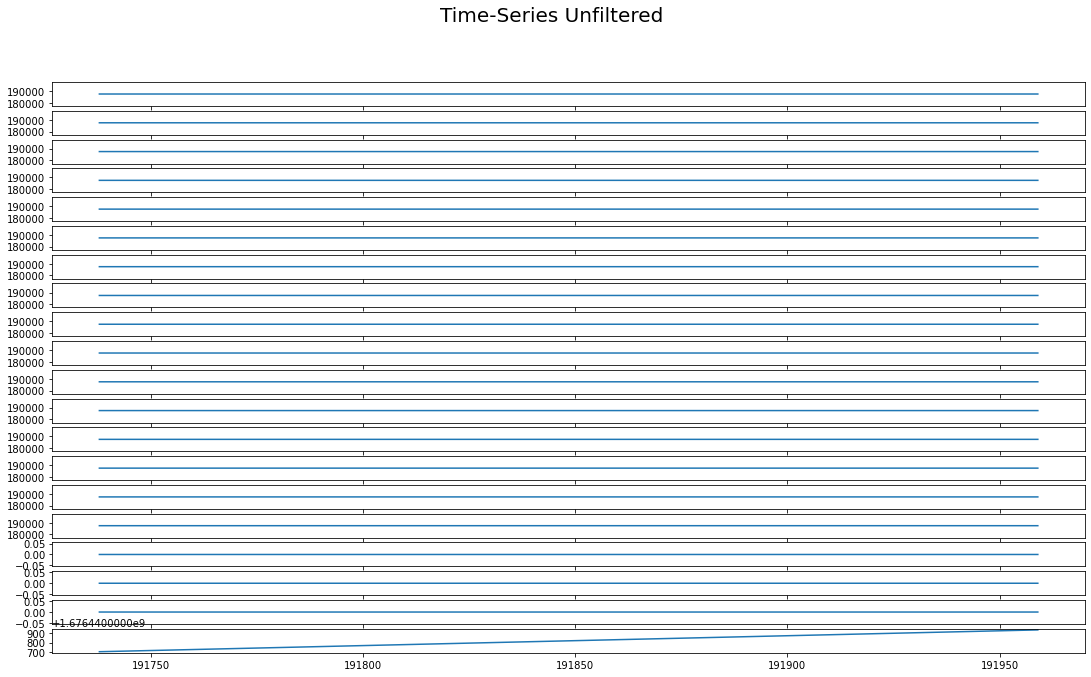

In [3]:
## Plot Time-Series Unfiltered ##
fig, axs = plt.subplots(channum)
for i in range(channum):
    axs[i].plot(data_X, data_Y[:,i])
    
fig.suptitle('Time-Series Unfiltered', fontsize=20)
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png',format='jpg')
#plt.close(fig)

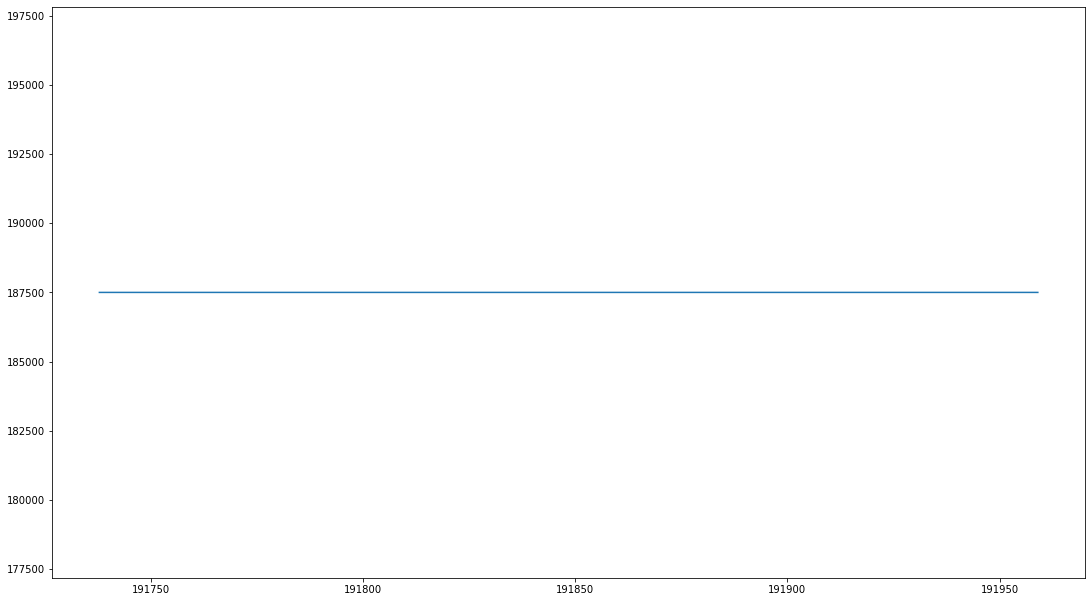

In [4]:
### Plot Single Time-Series Unfiltered ###
singlechan = 1
plt.figure(figsize=(18.5, 10.5))
plt.plot(data_X,data_Y[:,singlechan])


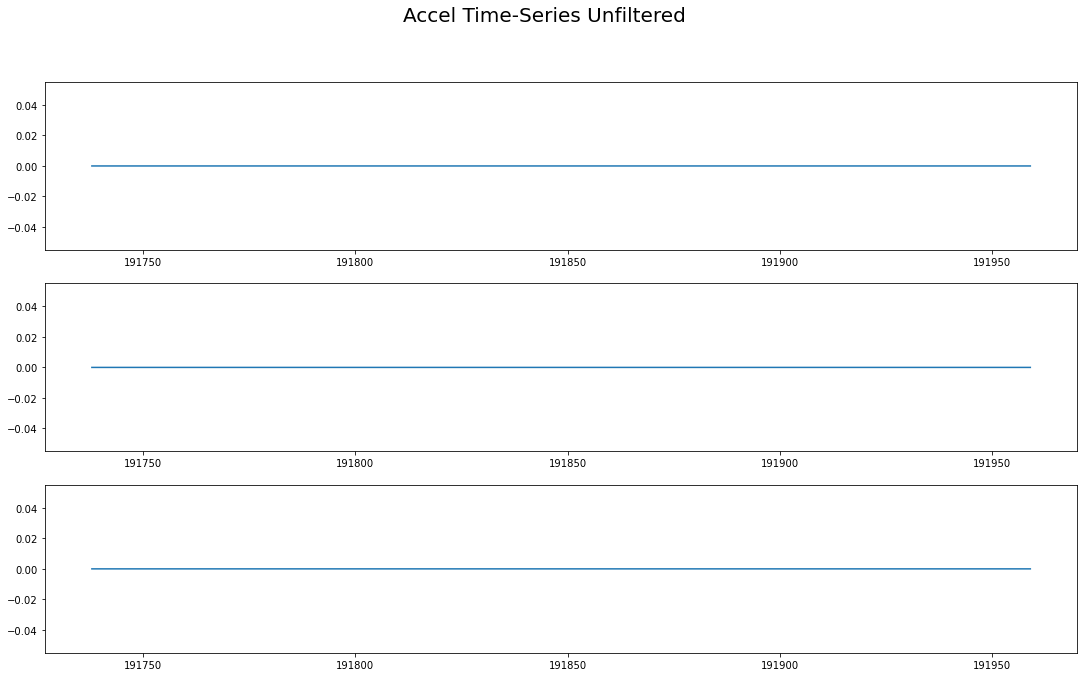

In [5]:
accel_channels = [16,17,18];
fig, axs = plt.subplots(len(accel_channels))
for i in range(len(accel_channels)):
    axs[i].plot(data_X, data_Y[:,accel_channels[i]])
    
fig.suptitle('Accel Time-Series Unfiltered', fontsize=20)
fig.set_size_inches(18.5, 10.5)

C:\Users\minle\anaconda3\envs\brainflow_conda_environments\lib\site-packages\matplotlib\axes\_axes.py:7200: RuntimeWarning: divide by zero encountered in log10
  line = self.plot(freqs, 10 * np.log10(pxx), **kwargs)
C:\Users\minle\anaconda3\envs\brainflow_conda_environments\lib\site-packages\matplotlib\axes\_axes.py:7200: RuntimeWarning: divide by zero encountered in log10
  line = self.plot(freqs, 10 * np.log10(pxx), **kwargs)
C:\Users\minle\anaconda3\envs\brainflow_conda_environments\lib\site-packages\matplotlib\axes\_axes.py:7200: RuntimeWarning: divide by zero encountered in log10
  line = self.plot(freqs, 10 * np.log10(pxx), **kwargs)
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=17.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 4

DEBUG:matplotlib.font_manager:findfont: score(<Font 'SWGothe' (swgothe.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Adobe Ming Std' (adobemingstd-light.otf) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (trebucbi.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tahoma' (tahoma.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Comic Sans MS' (comici.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'SWItalt' (switalt.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'SWRomns' (swromns.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Microsoft Yi Baiti' (msyi.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Malgun Gothic' (malgun

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Adobe Arabic' (adobearabic-bolditalic.otf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Palatino Linotype' (palabi.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Nirmala UI' (NirmalaS.ttf) normal normal 350 normal>) = 10.0975
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Microsoft PhagsPa' (phagspa.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Candara' (Candarab.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'SWMono' (swmono.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '3ds' (3ds Light.otf) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'SWComp' (swcomp.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Yu Gothic' (YuG

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Microsoft JhengHei' (msjhl.ttc) normal normal 290 normal>) = 10.1545
DEBUG:matplotlib.font_manager:findfont: score(<Font 'SWRomnt' (swromnt.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Segoe UI' (segoeui.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Unispace' (unispace bd.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (times.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Yu Gothic' (YuGothM.ttc) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Palatino Linotype' (palab.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'SWRomnd' (swromnd.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Corbel' (corbelli.ttf) 

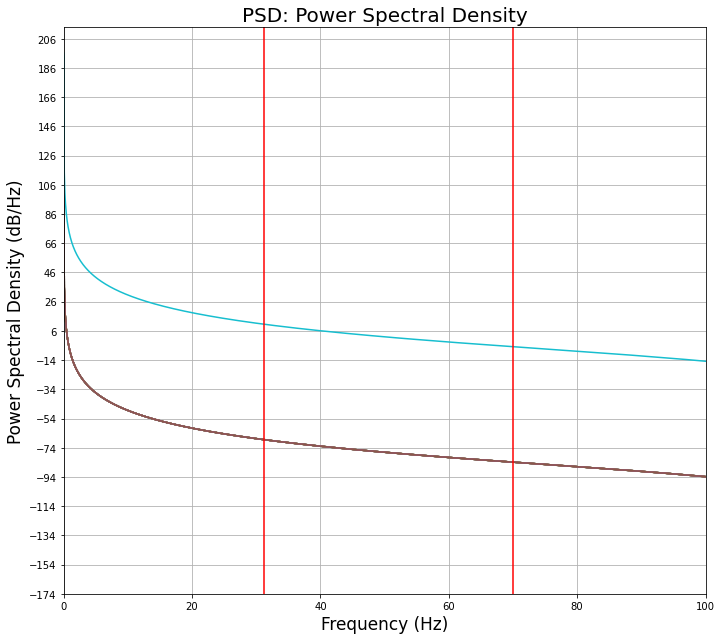

In [6]:
## PSD Unfiltered ##
plt.figure(figsize=(10, 9));
for i in range(channum):
    plt.psd(data_Y[:,i],NFFT=round(N/10),Fs=Fs);

plt.axvline(x=31.2, color = 'r')
plt.axvline(x=70, color = 'r')
plt.title('PSD: Power Spectral Density',fontsize=20);
plt.xlabel('Frequency (Hz)',fontsize=17);
plt.ylabel('Power Spectral Density (dB/Hz)',fontsize=17);
plt.tight_layout();
plt.xlim((0,100));
plt.show();

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=18.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_m

DEBUG:matplotlib.font_manager:findfont: score(<Font 'SWItalt' (switalt.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'SWRomns' (swromns.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Microsoft Yi Baiti' (msyi.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Malgun Gothic' (malgunsl.ttf) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kozuka Mincho Pr6N' (kozminpr6n-regular.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Segoe UI Historic' (seguihis.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Comic Sans MS' (comic.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mongolian Baiti' (monbaiti.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Fon

DEBUG:matplotlib.font_manager:findfont: score(<Font 'SWMono' (swmono.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '3ds' (3ds Light.otf) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'SWComp' (swcomp.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Yu Gothic' (YuGothB.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'OLF SimpleSansOC' (olfsimplesansoc-regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ebrima' (ebrimabd.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Segoe UI' (segoeuib.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ink Free' (Inkfree.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'SWMath' (swmath.ttf) normal nor

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Yu Gothic' (YuGothM.ttc) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Palatino Linotype' (palab.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'SWRomnd' (swromnd.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Corbel' (corbelli.ttf) italic normal 300 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (ariblk.ttf) normal normal 900 normal>) = 6.888636363636364
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (ariali.ttf) italic normal 400 normal>) = 7.413636363636363
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier Std' (courierstd-bold.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (verdanaz.ttf) italic normal 700 normal>) = 4.971363636363637
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ca

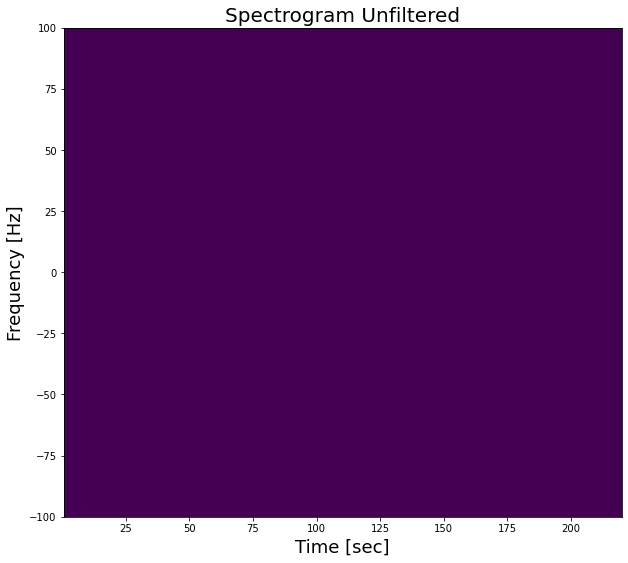

In [7]:
## Spectrogram Unfiltered ##
plt.figure(figsize=(10, 9));
freqs, time, Sxx = signal.spectrogram(data_Y[:,1], Fs,return_onesided=False)
plt.pcolormesh(time, fftshift(freqs), fftshift(Sxx,axes=0), shading='gouraud')
plt.title('Spectrogram Unfiltered',fontsize=20)
plt.ylabel('Frequency [Hz]',fontsize=18)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylim((-100,100))
plt.show()

In [8]:
## Apply Filter ##

# Initialize Variables
F0 = 60.0  # Frequency to be removed from signal (Hz)
Q = 30.0  # Quality factor

# Design notch filter
b, a = signal.iirnotch(F0, Q, Fs)
fdata_Y = [] 

# Apply Filter
for i in range(channum):
    fdata_Y.append(signal.filtfilt(b,a,data_Y[:,i]))

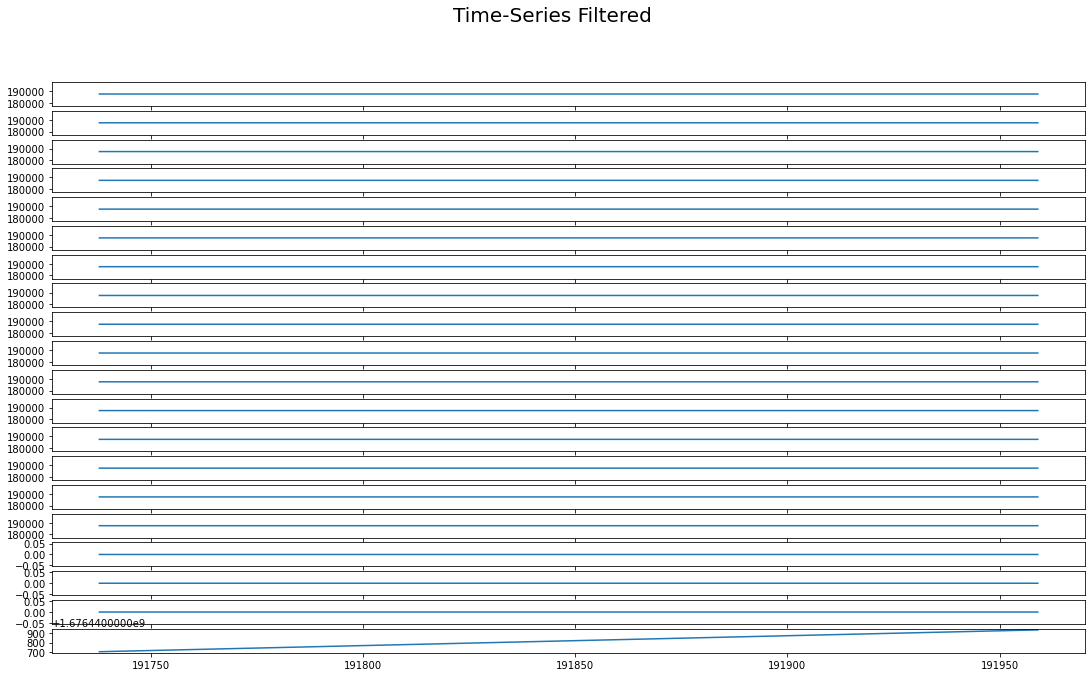

In [9]:
## Plot Time-Series Filtered ##
fig, axs = plt.subplots(channum) # define subplots

for i in range(channum):
    axs[i].plot(data_X, fdata_Y[i])
    
fig.suptitle('Time-Series Filtered', fontsize=20)
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png',format='jpg')
#plt.close(fig)

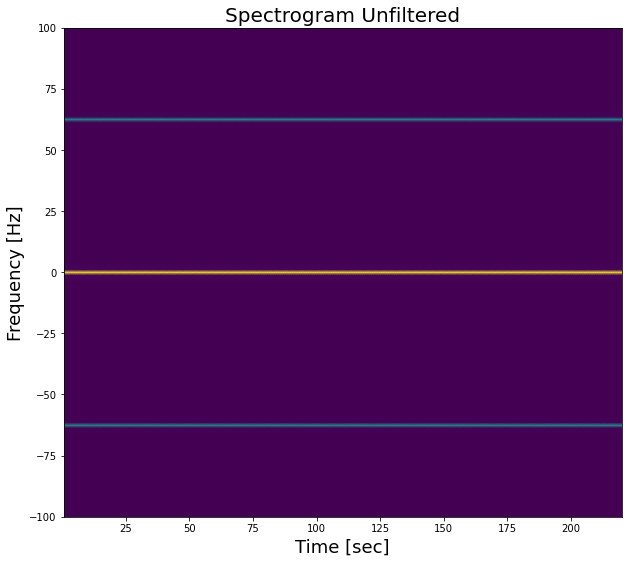

In [10]:
## Spectrogram Filtered ##
plt.figure(figsize=(10, 9));
freqs, time, Sxx = signal.spectrogram(fdata_Y[1], Fs,return_onesided=False)
plt.pcolormesh(time, fftshift(freqs), fftshift(Sxx,axes=0), shading='gouraud')
plt.title('Spectrogram Unfiltered',fontsize=20)
plt.ylabel('Frequency [Hz]',fontsize=18)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylim((-100,100))
plt.show()

C:\Users\minle\anaconda3\envs\brainflow_conda_environments\lib\site-packages\matplotlib\axes\_axes.py:7200: RuntimeWarning: divide by zero encountered in log10
  line = self.plot(freqs, 10 * np.log10(pxx), **kwargs)
C:\Users\minle\anaconda3\envs\brainflow_conda_environments\lib\site-packages\matplotlib\axes\_axes.py:7200: RuntimeWarning: divide by zero encountered in log10
  line = self.plot(freqs, 10 * np.log10(pxx), **kwargs)
C:\Users\minle\anaconda3\envs\brainflow_conda_environments\lib\site-packages\matplotlib\axes\_axes.py:7200: RuntimeWarning: divide by zero encountered in log10
  line = self.plot(freqs, 10 * np.log10(pxx), **kwargs)


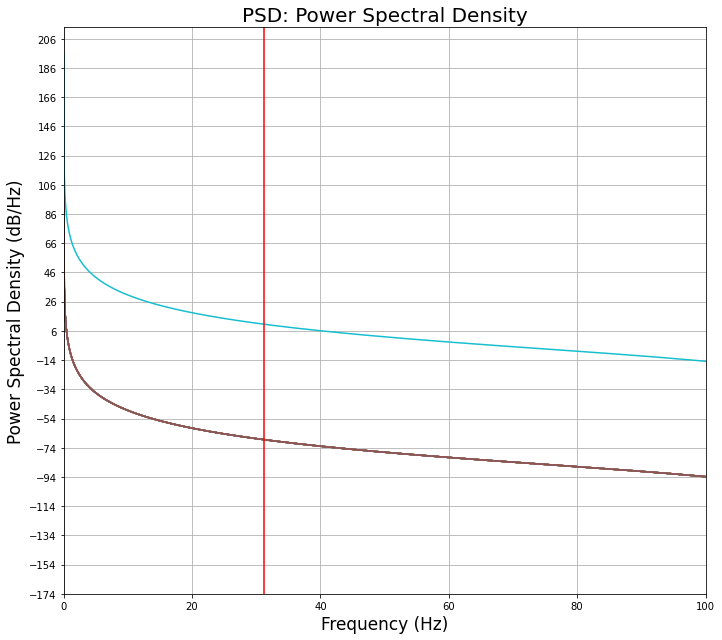

In [11]:
# PSD Filtered ##
plt.figure(figsize=(10, 9));
for i in range(channum):
    plt.psd(fdata_Y[i],NFFT=round(N/10),Fs=Fs);

plt.axvline(x=31.2, color = 'r');
plt.title('PSD: Power Spectral Density',fontsize=20);
plt.xlabel('Frequency (Hz)',fontsize=17);
plt.ylabel('Power Spectral Density (dB/Hz)',fontsize=17);
plt.tight_layout();
plt.xlim((0,100));
plt.show();